# Определение перспективного тарифа для телеком-компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. Компания предоставила данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

Тариф «Смарт»

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета: 
1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
2. сообщение: 3 рубля; 
3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета: 
1. минута разговора: 1 рубль; 
2. сообщение: 1 рубль; 
3. 1 Гб интернет-трафика: 150 рублей.

Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# зададим необходимые константы - количество мегабайт в гигабайте
MB_IN_GB = 1024

## Изучение данных из файла

Откроем файлы с данными и изучим общую информацию.

### Звонки

In [4]:
calls = pd.read_csv('/datasets/calls.csv')

In [5]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


### Интернет

In [7]:
internet = pd.read_csv('/datasets/internet.csv')

In [8]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Появился лишний столбец, дублирующий номера строк. Попробуем прочитать датаст по-другому.

In [9]:
internet = pd.read_csv('/datasets/internet.csv',  index_col=0)

In [10]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Теперь датсет прочитан правильно.

In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


### Сообщения

In [12]:
messages = pd.read_csv('/datasets/messages.csv')

In [13]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


### Тарифы

In [15]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [16]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Пользователи

In [18]:
users = pd.read_csv('/datasets/users.csv')

In [19]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Вывод

Данные распределены по пяти датасетам:
* calls
* internet
* messages
* tariffs
* users

Данные о звонках, траффике и сообщениях могут быть связаны с данными о пользователях через столбец `user_id`, данные о тарифе - через столбец `tariff_name`, для этого целесообразно переименовать столбец `tariff` таблицы `users` в `tariff_name`.

Пропуски в данных есть только в датасете `users` в столбце `churn_date` - видимо данных нет для тех клиентов, кто все еще остается с Мегалайном. Эти пропуски можно заполнить датой 31.12.2018 - так как данные мы будем анализировать только за 2018 год.

Изменение типов данных требуется для столбцов с датами - перевод их в тип datetime.

Также необходимо проверить на аномалии колонку с возрастом абонентов и проверить текстовые столбцы на ошибки и опечатки.

## Предобработка данных

### Заполнение пропусков

Заполним пропуски в столбце `churn_date` датасета `users`. Так как мы анализируем данные только за 2018 год, то вместо даты отключения можно поставить последний день 2018 года - это ни на что не повлияет.

In [21]:
users['churn_date'] = users['churn_date'].fillna('2018-12-31')

In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропуски заполнены.

### Изменение типов данных

Изменим тип данных в столбцах с датами - переводем их в тип datetime.

In [23]:
calls['call_date'] = pd.to_datetime(calls['call_date'], yearfirst=True)

In [24]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [25]:
internet['session_date'] = pd.to_datetime(
    internet['session_date'], yearfirst=True)

In [26]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [27]:
messages['message_date'] = pd.to_datetime(
    messages['message_date'], yearfirst=True)

In [28]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [29]:
users['reg_date'] = pd.to_datetime(users['reg_date'], yearfirst=True)

In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


Все необходимые преобразования типов данных выполнены.

### Исправление ошибок

Переименуем столбец `tariffs` в таблице `users`, чтобы он соответствовал аналогичному столбцу таблицы `tariffs`

In [31]:
users = users.rename(columns={'tariff': 'tariff_name'})

In [32]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Теперь по одинаково проименованным столбцам можно будет производить объединение таблиц.

Проверим текстовые столбцы, они могут быть заполнены произвольно и в них могут встречаться ошибки.

In [33]:
sorted(users['city'].unique())

['Архангельск',
 'Астрахань',
 'Балашиха',
 'Барнаул',
 'Белгород',
 'Брянск',
 'Владивосток',
 'Владикавказ',
 'Владимир',
 'Волгоград',
 'Волжский',
 'Вологда',
 'Воронеж',
 'Грозный',
 'Екатеринбург',
 'Иваново',
 'Ижевск',
 'Иркутск',
 'Казань',
 'Калининград',
 'Калуга',
 'Кемерово',
 'Киров',
 'Кострома',
 'Краснодар',
 'Красноярск',
 'Курган',
 'Курск',
 'Липецк',
 'Магнитогорск',
 'Махачкала',
 'Москва',
 'Мурманск',
 'Набережные Челны',
 'Нижневартовск',
 'Нижний Новгород',
 'Нижний Тагил',
 'Новокузнецк',
 'Новороссийск',
 'Новосибирск',
 'Омск',
 'Оренбург',
 'Орёл',
 'Пенза',
 'Пермь',
 'Петрозаводск',
 'Подольск',
 'Ростов-на-Дону',
 'Рязань',
 'Самара',
 'Санкт-Петербург',
 'Саранск',
 'Саратов',
 'Севастополь',
 'Смоленск',
 'Сочи',
 'Ставрополь',
 'Стерлитамак',
 'Сургут',
 'Тамбов',
 'Тверь',
 'Тольятти',
 'Томск',
 'Тула',
 'Тюмень',
 'Улан-Удэ',
 'Ульяновск',
 'Уфа',
 'Хабаровск',
 'Химки',
 'Чебоксары',
 'Челябинск',
 'Череповец',
 'Чита',
 'Якутск',
 'Ярославль']

In [34]:
sorted(users['first_name'].unique())

['Авксентий',
 'Агата',
 'Агафья',
 'Агнесса',
 'Адам',
 'Аким',
 'Аксён',
 'Алан',
 'Алевтина',
 'Александр',
 'Александра',
 'Алексей',
 'Алина',
 'Алиса',
 'Алла',
 'Альберта',
 'Альбин',
 'Альфред',
 'Алёна',
 'Анатолий',
 'Анвар',
 'Ангелина',
 'Андрей',
 'Анжелика',
 'Анита',
 'Антонина',
 'Анфиса',
 'Арина',
 'Арнольд',
 'Арсен',
 'Арсений',
 'Артемий',
 'Артём',
 'Аурелия',
 'Афанасий',
 'Ахмет',
 'Аюна',
 'Белла',
 'Берта',
 'Борис',
 'Вадим',
 'Валентина',
 'Валерий',
 'Валерия',
 'Варвара',
 'Варлам',
 'Василиса',
 'Вениамин',
 'Вера',
 'Вероника',
 'Веселина',
 'Виктор',
 'Виктория',
 'Виолетта',
 'Виталий',
 'Владимир',
 'Владислав',
 'Владислава',
 'Всеволод',
 'Габриель',
 'Габриэль',
 'Гайдар',
 'Галина',
 'Гарри',
 'Гектор',
 'Гелена',
 'Геннадий',
 'Геодар',
 'Георгий',
 'Георгина',
 'Геральд',
 'Герасим',
 'Глеб',
 'Гордей',
 'Григорий',
 'Дайна',
 'Дана',
 'Даниил',
 'Даниэла',
 'Дебора',
 'Демьян',
 'Денис',
 'Джемма',
 'Джозефина',
 'Джулия',
 'Динара',
 'Доминика

In [35]:
sorted(users['last_name'].unique())

['Ёлчина',
 'Ёркин',
 'Ёркина',
 'Ёрохов',
 'Ёрохова',
 'Абаимов',
 'Абакумов',
 'Абакшина',
 'Абалакова',
 'Абалдуева',
 'Абалкин',
 'Абашкин',
 'Абашкина',
 'Абдулина',
 'Абоимов',
 'Абрамович',
 'Абрамцев',
 'Абрамычева',
 'Абрашина',
 'Абрикосова',
 'Авдеев',
 'Авдеенко',
 'Авдонюшкин',
 'Авдушева',
 'Авдышев',
 'Авдюков',
 'Авраамова',
 'Авраменко',
 'Авринский',
 'Аврорин',
 'Авроров',
 'Авросимова',
 'Авросинова',
 'Авсейкина',
 'Авчинникова',
 'Агаев',
 'Агаева',
 'Агапеева',
 'Агеева',
 'Адаменко',
 'Адамов',
 'Азаров',
 'Азерников',
 'Азимова',
 'Акимов',
 'Акимчин',
 'Акимычева',
 'Акиндинов',
 'Акинин',
 'Акинфьев',
 'Аксёнов',
 'Акуленко',
 'Александрова',
 'Александрович',
 'Александрюк',
 'Алексеева',
 'Алексеенко',
 'Алексеичев',
 'Аленникова',
 'Алесин',
 'Алехина',
 'Алешин',
 'Алешина',
 'Алешкова',
 'Алиев',
 'Алфеева',
 'Алфимов',
 'Алфимова',
 'Алымова',
 'Алютин',
 'Алюшина',
 'Алёшко',
 'Алёшкова',
 'Амелин',
 'Амелишко',
 'Амельченко',
 'Ананьева',
 'Андреенко'

Ошибок нет

Проверим столбец `age` датасета `users`.

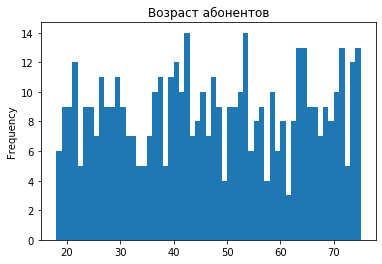

In [36]:
users['age'].plot(kind='hist', bins=57, title='Возраст абонентов')

Аномалий нет.

Все ошибки исправлены.

### Проверка на дубликаты

Проверим все датасеты на дубликаты.

In [37]:
calls.duplicated().sum()

0

In [38]:
messages.duplicated().sum()

0

In [39]:
internet.duplicated().sum()

0

In [40]:
users.duplicated().sum()

0

In [41]:
users[['first_name', 'last_name']].duplicated().sum()

0

Дубликатов ни в одном датасете нет. 

### Вывод

Мы заполнили пропуски, изменили типы данных в необходимых местах, исправили ошибки и сделали пропверку на дубликаты. Теперь данные готовы к дальнейшей работе.

## Расчеты

Посчитаем для каждого пользователя:

количество сделанных звонков и израсходованных минут разговора по месяцам;

количество отправленных сообщений по месяцам;

объем израсходованного интернет-трафика по месяцам;

помесячную выручку.

### Количество сделанных звонков и израсходованных минут разговора

Для расчета количества сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя составим сводную таблицу. Необходимо учесть, что при расчетах длительность каждого звонка округляется в большую сторону.

In [115]:
calls['duration'] = np.ceil(calls['duration'])
users_calls = calls.pivot_table(index=['user_id', pd.DatetimeIndex(calls['call_date']).month],
                                values='duration',
                                aggfunc=['count', 'sum']).reset_index()
users_calls.columns = ['user_id', 'month', 'call_number', 'call_duration']
users_calls.head()

,user_id,month,call_number,call_duration
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0


### Количество отправленных сообщений

Через сводную таблицу подсчитаем количество отправленных сообщений по месяцам для каждого пользователя.

In [116]:
users_messages = messages.pivot_table(index=['user_id', pd.DatetimeIndex(messages['message_date']).month],
                                      values='id',
                                      aggfunc='count').reset_index()
users_messages.columns = ['user_id', 'month', 'message_number']

In [117]:
users_messages.head()

,user_id,month,message_number
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Объем израсходованного интернет-трафика

Также рассчитаем объем израсходованного интернет-трафика. При расчете необходимо перевести мегабайти в гигабайты, так как именно в них будут проводиться дальнейшие расчеты.

In [45]:
users_internet = internet.pivot_table(index=['user_id', pd.DatetimeIndex(internet['session_date']).month],
                                      values='mb_used',
                                      aggfunc=lambda x: sum(x)/MB_IN_GB).reset_index()
users_internet.columns = ['user_id', 'month', 'gb_used']

In [46]:
users_internet.head()

,user_id,month,gb_used
0,1000,5,2.200674
1,1000,6,22.689229
2,1000,7,13.675430
3,1000,8,13.726494
4,1000,9,14.227451


### Помесячная выручка с каждого пользователя

Для расчета помесячной выручки соберем все данные в одну таблицу.

In [183]:
users_total = users_calls.merge(
    users_messages, on=['user_id', 'month'], how='outer')

In [184]:
users_total = users_total.merge(
    users_internet, on=['user_id', 'month'], how='outer')

In [185]:
users_total = users_total.merge(users, on='user_id', how='outer')

Проверим, правильно ли прошло присоединение. Сравним суммарное количество минут разговора, сообщений и траффика в исходных таблицах и в финальной.

In [186]:
if (users_total['call_duration'].sum() == calls['duration'].sum() and
    users_total['message_number'].sum() == messages['id'].count() and
        users_total['gb_used'].sum() == (internet['mb_used'].sum()/MB_IN_GB)):
    print('Объединение прошло успешно')
else:
    print('объединение прошло с ошибкой!')

Объединение прошло успешно


Удалим неважные для анализа столбцы.

In [187]:
users_total.drop(['age', 'first_name', 'last_name', ],
                 axis='columns', inplace=True)

In [188]:
users_total.head()

,user_id,month,call_number,call_duration,message_number,gb_used,churn_date,city,reg_date,tariff_name
0,1000,5.0,22.0,159.0,22.0,2.200674,2018-12-31,Краснодар,2018-05-25,ultra
1,1000,6.0,43.0,172.0,60.0,22.689229,2018-12-31,Краснодар,2018-05-25,ultra
2,1000,7.0,47.0,340.0,75.0,13.675430,2018-12-31,Краснодар,2018-05-25,ultra
3,1000,8.0,52.0,408.0,81.0,13.726494,2018-12-31,Краснодар,2018-05-25,ultra
4,1000,9.0,58.0,466.0,57.0,14.227451,2018-12-31,Краснодар,2018-05-25,ultra


Из-за появления пропущенных значений тип данных меняется на float. Однако в колонке `month` пропущенных значений быть не может. Исследуем эти пропуски.

In [189]:
users_total[users_total['month'].isna()]

,user_id,month,call_number,call_duration,message_number,gb_used,churn_date,city,reg_date,tariff_name
3214,1128,NaN,NaN,NaN,NaN,NaN,2018-12-23,Волжский,2018-12-15,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,2018-12-30,Омск,2018-12-25,smart


Два человека подключили тариф, провели на нем несколько дней, не пользуясь никакими услугами,  и затем сразу же отключились. Для анализа они не интересны, поэтому можно удалить их из таблицы.

In [190]:
users_total.dropna(subset=['month'], inplace=True)

Для расчета выручки просоединим к таблице условия тарифов.

In [191]:
users_total = users_total.merge(tariffs, on='tariff_name', how='outer')

In [192]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [193]:
users_total.head()

,user_id,month,call_number,call_duration,message_number,gb_used,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,22.0,2.200674,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,60.0,22.689229,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,75.0,13.675430,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,81.0,13.726494,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,57.0,14.227451,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Теперь рассчитаем все услуги, оказанные сверх тарифного пакета. 

Рассчитаем количество минут, вышедшее за рамки тарифа.

In [195]:
users_total['add_minutes'] = (users_total['call_duration'] -
                              users_total['minutes_included']).apply(lambda x: max(x, 0))

In [132]:
users_total['add_minutes'].fillna(0, inplace=True)

In [133]:
users_total['add_minutes']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
30        0.0
31        0.0
32        0.0
33        0.0
34        0.0
35        0.0
36        0.0
37        0.0
38        0.0
39        0.0
40        0.0
41        0.0
42        0.0
43        0.0
44        0.0
45        0.0
46        0.0
47        0.0
48        0.0
49        0.0
50        0.0
51        0.0
52        0.0
53        0.0
54        0.0
55        0.0
56        0.0
57        0.0
58        0.0
59        0.0
60        0.0
61        0.0
62        0.0
63        0.0
64        0.0
65        0.0
66        0.0
67        0.0
68        0.0
69        0.0
70        0.0
71    

Рассчитаем количество сообщений, вышедшее за рамки тарифа.

In [135]:
users_total['add_messages'] = (users_total['message_number'] -
                               users_total['messages_included']).apply(lambda x: max(x, 0))

In [136]:
users_total['add_messages'].fillna(0, inplace=True)

Рассчитаем количество гигабайт, вышедшее за рамки тарифа. Округлим в большую сторону, так как оплата берется за 1 гигабайт.

In [137]:
users_total['add_gb'] = (np.ceil(users_total['gb_used'] -
                                 (users_total['mb_per_month_included'] / MB_IN_GB))).apply(lambda x: max(x, 0))

In [138]:
users_total['add_gb'].fillna(0, inplace=True)

Расчитаем выручку

In [139]:
users_total['total_price'] = (users_total['add_minutes'] * users_total['rub_per_minute']
                              + users_total['add_messages'] *
                              users_total['rub_per_message']
                              + users_total['add_gb'] *
                              users_total['rub_per_gb']
                              + users_total['rub_monthly_fee'])

In [140]:
users_total.head()

,user_id,month,call_number,call_duration,message_number,gb_used,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,add_minutes,add_messages,add_gb,total_price
0,1000,5.0,22.0,159.0,22.0,2.200674,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6.0,43.0,172.0,60.0,22.689229,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,7.0,47.0,340.0,75.0,13.675430,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8.0,52.0,408.0,81.0,13.726494,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9.0,58.0,466.0,57.0,14.227451,2018-12-31,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


In [141]:
users_total.tail()

,user_id,month,call_number,call_duration,message_number,gb_used,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,add_minutes,add_messages,add_gb,total_price
3209,1489,8.0,NaN,NaN,17.0,10.791562,2018-12-31,Санкт-Петербург,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0,550.0
3210,1489,9.0,NaN,NaN,32.0,16.803027,2018-12-31,Санкт-Петербург,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,0.0,2.0,950.0
3211,1489,10.0,NaN,NaN,21.0,19.101016,2018-12-31,Санкт-Петербург,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,0.0,5.0,1550.0
3212,1489,11.0,NaN,NaN,20.0,17.081602,2018-12-31,Санкт-Петербург,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,0.0,3.0,1150.0
3213,1489,12.0,NaN,NaN,35.0,16.916514,2018-12-31,Санкт-Петербург,2018-08-15,smart,50,15360,500,550,200,3,3,0.0,0.0,2.0,950.0


### Вывод

Мы составили таблицу, в которой для каждого пользователя посчитано количество сделанных звонков и израсходованных минут разговора, количество отправленных сообщений и объем израсходованного интернет-трафика по месяцам, а также помесячная выручка.

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Изучим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы и опишем распределения.

### Подготовка к анализу

Удалим из таблицы данные о тарифах, так как они не понядобятся нам для анализа.

In [142]:
users_total.drop(['messages_included', 'mb_per_month_included',
                  'minutes_included', 'rub_monthly_fee', 'rub_per_gb',
                  'rub_per_message', 'rub_per_minute'], axis='columns', inplace=True)

Разобьем таблицу на две соответственно тарифу. Узнаем размер получившихся выборок, это будет важно в будущем при проверке гипотез.

In [143]:
data_smart = users_total[users_total['tariff_name'] == 'smart']

In [144]:
len(data_smart)

2229

In [145]:
data_ultra = users_total[users_total['tariff_name'] == 'ultra']

In [146]:
len(data_ultra)

985

У нас получилось две таблицы: smart, с данными пользователей на тарифе Smart, и ultra, с данными пользователей на  тарифе Ultra. Таблица smart содержит 2229 записей о помесячном пользовании тарифом, а таблица ultra - 985. Размеры выборок сильно отличаются, будем учитывать это в дальнейшем.

Теперь сравним таблицы. Составим сводные таблицы со средними показателями по месяцам:

In [147]:
data_smart_mean = data_smart.pivot_table(index='month',
                                         values=['call_duration',
                                                 'message_number', 'gb_used'],
                                         aggfunc='mean')
data_ultra_mean = data_ultra.pivot_table(index='month',
                                         values=['call_duration',
                                                 'message_number', 'gb_used'],
                                         aggfunc='mean')

Напишем функции для выведения графиков.

In [148]:
def mean_plot(column, title, smart_limit, ultra_limit=0, ultra_limit_show=False):
    """
    Функция выводит график среднего по месяцам по указанному в колонке column значению.
    title - название графика
    smart_limit - лимит по исследуемому значению на тарифе Смарт
    ultra_limit - лимит по исследуемому значению на тарифе Ультра
    ultra_limit_show - необходимо ли показывать лимит по тарифу Ультра
    """
    data_smart_mean[column].plot(style='o-', grid=True,
                                 legend=True, label='Смарт',
                                 title=title)
    data_ultra_mean[column].plot(style='o-', grid=True,
                                 legend=True, label='Ультра', figsize=(12, 5))
    plt.axhline(smart_limit, c='blue', linestyle='--', alpha=.5)
    if ultra_limit_show:
        plt.axhline(ultra_limit, c='orange', linestyle='--', alpha=.5)
    plt.show()

In [149]:
def density_plot(xlabel, text, column):
    """
    Функция выводит график распределения плотности по указанному в колонке column значению.
    text - название исследуемого значения в названии графика
    xlabel - название оси x
    """
    plt.xlabel(xlabel)
    plt.ylabel('плотность распределения')
    plt.title('Сопоставление распределения ' + text + ' по тарифам')
    sns.kdeplot(data_smart[column], shade=True, label="Smart")
    sns.kdeplot(data_ultra[column], shade=True, label="Ultra")
    plt.show()

### Количество минут в месяц

Сравним, какое количество минут тратят в месяц пользователи разных тарифов. Построим график со средним количеством потраченых минут в месяц для каждого тарифа.

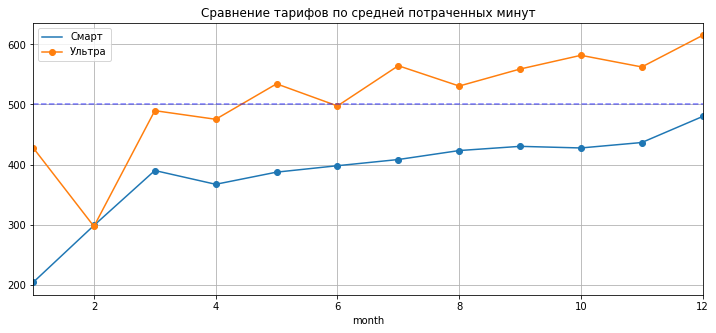

In [150]:
mean_plot('call_duration', 'Сравнение тарифов по средней потраченных минут', 500)

На графике выше синей пунктирной горизонтальной линией отмечен лимит по количеству минут на тарифе Смарт. Мы видим, что пользователи тарифа в среднем укладываются в этот лимит. Лимит на тарифе Ультра составляет 3000 минут, он не выведен на график, так как находится очень высоко от основных линий и очевидно пользователи тарифа Ультра в этот лимит также укладываются. На графике виден тренд на возрастание количества потраченых минут с течением времени. В феврале на тарифе Ультра резкий провал, которого нет на тарифе Смарт - возможно это некорректные данные, либо в феврале у пользователей этого тарифа были какие-то проблемы с обслуживанием.

Вычислим среднее количество, дисперсию и стандартное отклонение количества потраченных минут по тарифам.

In [151]:
data_smart['call_duration'].describe()

count    2223.000000
mean      419.062978
std       189.325618
min         0.000000
25%       285.000000
50%       423.000000
75%       545.500000
max      1435.000000
Name: call_duration, dtype: float64

In [152]:
np.var(data_smart['call_duration'], ddof=1)

35844.1895513438

In [153]:
data_ultra['call_duration'].describe()

count     951.000000
mean      545.451104
std       306.925754
min         0.000000
25%       310.000000
50%       528.000000
75%       756.500000
max      1673.000000
Name: call_duration, dtype: float64

In [154]:
np.var(data_ultra['call_duration'], ddof=1)

94203.41839614812

Длительность разговоров на тарифе Смарт находиться в промежуткке от 0 до 1435 минут, на тарифе Ультра - от 0 до 1673. В среднем на тарифе Смарт пользователи тратят 419 минут в месяц, а на тарифе Ультра - 545. Медианное значение длительности разговора для тарифа Смарт - 423, а для тарифа Ультра - 528, то есть распределение на тарифе Смарт немного скошено влево, а на тарифе Ультра - вправо.

Теперь построим сравнительный график для плотности распределения длительности разговора в месяц для двух тарифов.

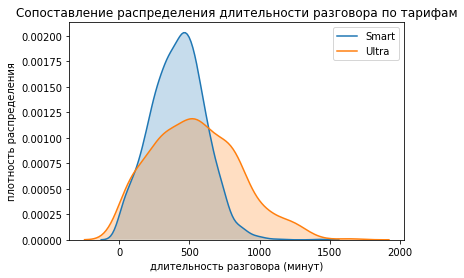

In [155]:
density_plot('длительность разговора (минут)',
             'длительности разговора', 'call_duration')

На графике мы видим, что для пользователей тарифа Смарт более характерно тратить чуть меньше 500 минут в месяц, что является лимитом на этом тарифе, а для пользователей тарифа Ультра - чуть больше 500. Размах значений на тарифе Ультра гораздо больше, чем на тарифе Смарт, что также можно увидеть сравнив диспресию обоих тарифов (35884 и 94203 для тарифа Смарт и Ультра соответственно).

### Количество сообщений

Сравним количество сообщений в месяц у пользователей разных тарифов. Построим график среднего количества сообщений по месяцам.

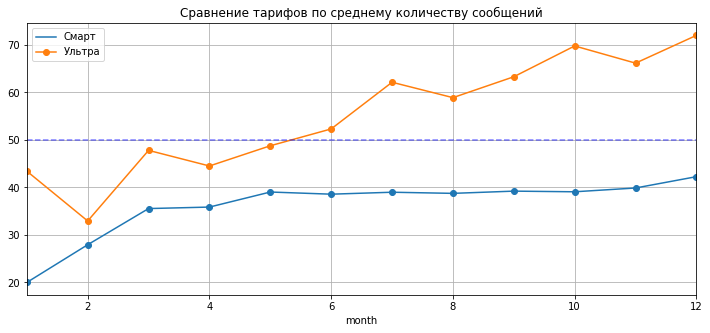

In [156]:
mean_plot('message_number',
          'Сравнение тарифов по среднему количеству сообщений', 50)

На графике выше синей пунктирной горизонтальной линией отмечен лимит по количеству сообщений на тарифе Смарт. Мы видим, что пользователи тарифа в среднем укладываются в этот лимит. Лимит на тарифе Ультра составляет 1000 сообщений, он не выведен на график, так как находится очень высоко от основных линий и пользователи тарифа Ультра в этот лимит также укладываются. На графике виден тренд на возрастание количества отправленных сообщений с течением времени, на тарифе Ультра рост более резкий. В феврале на тарифе Ультра резкий провал, которого нет на тарифе Смарт - возможно это некорректные данные, либо в феврале у пользователей этого тарифа были какие-то проблемы с обслуживанием.

Вычислим среднее количество, дисперсию и стандартное отклонение количества сообщений по тарифам.

In [157]:
data_smart['message_number'].describe()

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: message_number, dtype: float64

In [158]:
np.var(data_smart['message_number'], ddof=1)

717.5942011753547

In [159]:
data_ultra['message_number'].describe()

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: message_number, dtype: float64

In [160]:
np.var(data_ultra['message_number'], ddof=1)

2109.6591828651995

Количество сообщений на тарифе Смарт находится в промежутке от 1 до 143, на тарифе Ультра - от 1 до 224. В среднем на тарифе Смарт пользователи отправляют 39 сообщений в месяц, а на тарифе Ультра - 61. Медианное значение количества использованных сообщений для тарифа Смарт - 34, а для тарифа Ультра - 51, то есть распределение на обоих тарифах скошено вправо.

Теперь построим сравнительный график для плотности распределения количества сообщений в месяц для двух тарифов.

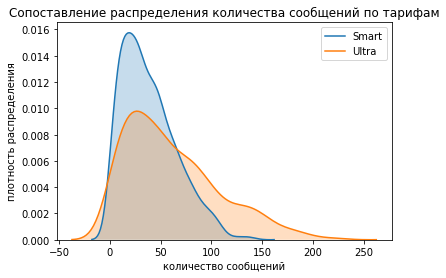

In [161]:
density_plot('количество сообщений', 'количества сообщений', 'message_number')

На графике мы видим, что для пользователей тарифа Смарт более характерно тратить около 30 сообщений в месяц, а для пользователей тарифа Ультра - чуть больше. Размах значений на тарифе Ультра гораздо больше, чем на тарифе Смарт, что также можно увидеть сравнив диспресию обоих тарифов (718 и 2109 для тарифа Смарт и Ультра соответственно).

### Объем интернет-трафика

Сравним объем трафика в гигабайтах у пользователей разных тарифов. Построим график среднего количества использованных гигабайт по месяцам.

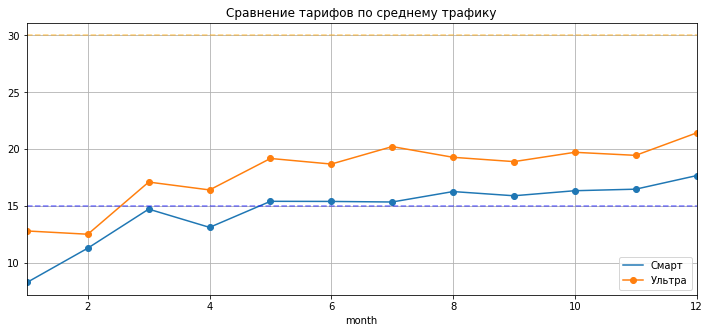

In [162]:
mean_plot('gb_used', 'Сравнение тарифов по среднему трафику', 15360 /
          MB_IN_GB, ultra_limit_show=True, ultra_limit=30720 / MB_IN_GB)

На графике выше синей пунктирной горизонтальной линией отмечен лимит по количеству сообщений на тарифе Смарт, а оранжевой - на тарифе Ультра. Мы видим, что пользователи обоих тарифов в среднем укладываются в этот лимит. На графике виден тренд на возрастание количества использованного траффика с течением времени. 

In [163]:
data_smart['gb_used'].describe()

count    2228.000000
mean       15.835607
std         5.724352
min         0.000000
25%        12.352805
50%        16.120840
75%        19.574016
max        37.648877
Name: gb_used, dtype: float64

In [164]:
np.var(data_smart['gb_used'], ddof=1)

32.76820343235317

In [165]:
data_ultra['gb_used'].describe()

count    975.000000
mean      19.207505
std        9.710010
min        0.000000
25%       11.726860
50%       18.939736
75%       26.266162
max       48.579775
Name: gb_used, dtype: float64

In [166]:
np.var(data_ultra['gb_used'], ddof=1)

94.28429503691821

Объем использованного трафика на тарифе Смарт находится в промежутке от 0 до 38 Гб, на тарифе Ультра - от 0 до 49 Гб. В среднем на тарифе Смарт пользователи используют 16 Гб в месяц, а на тарифе Ультра - 19. Медианное значение количества использованных гигабайт для тарифа Смарт - 16, а для тарифа Ультра - 19, то есть распределение на обоих тарифах практически симметрично.

Теперь построим сравнительный график для плотности распределения объема использованного трафика в месяц для двух тарифов.

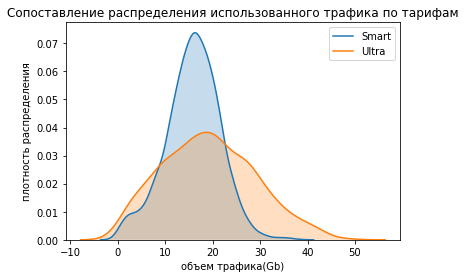

In [167]:
density_plot('объем трафика(Gb)', 'использованного трафика', 'gb_used')

На графике мы видим, что для пользователей тарифа Смарт более характерно тратить около 16 гигабайт в месяц, а для пользователей тарифа Ультра - около 19. Размах значений на тарифе Ультра гораздо больше, чем на тарифе Смарт, что также можно увидеть сравнив диспресию обоих тарифов (33 и 94 для тарифа Смарт и Ультра соответственно).

### Вывод

Мы провели анализ данных и сравнили тарифы по количеству минут разговора, сообщений и объёму интернет-трафика необходимых пользователям каждого тарифа в месяц. Для тарифа Ультра характерны более высокие значения среднего и медианы для всех исследуемых опций и более высокий размах значений (те более высокая дисперсия и стандартное отклонение)

## Проверка гипотез

### Различие средней выручки на тарифах «Ультра» и «Смарт»

Формулируем нулевую гипотезу H₀. H₀ всегда формулируется так, чтобы использовать знак равенства. В данном случае H₀ будет звучать так:

"Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равны."

Альтернативная гипотезу H1 для этой нулевой гипотезы на данном этапе можно сформулировать так:

"Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются."

Однако попробуем сравнить средние выручки по двум тарифам и предположить более точную одностороннюю альтернативную гипотезу.

In [168]:
smart_mean = data_smart['total_price'].mean()
ultra_mean = data_ultra['total_price'].mean()

print('Средняя выручка на тарифе Смарт: ', smart_mean)
print('Средняя выручка на тарифе Ультра: ', ultra_mean)

Средняя выручка на тарифе Смарт:  1289.9735307312696
Средняя выручка на тарифе Ультра:  2070.1522842639592


Выручка на тарифе Ультра кажется сильно больше. Сформулируем новую пару гипотез.

Гипотеза H₀:

"Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равны."

Альтернативная гипотеза H1:

"Средняя выручка пользователей тарифов «Ультра» больше, чем пользователей тарифа «Смарт»."

Для проверки гипотез будем использовать специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

Как как мы показали выше, размеры выборок сильно отличаются. Сравним их дисперсии, чтобы правильно задать параметр `equal_var`. 

In [169]:
np.var(data_smart['total_price'], ddof=1)

669785.7080064242

In [170]:
np.var(data_ultra['total_price'], ddof=1)

141516.7450786183

Дисперсии сильно отличаются, лучше задать `equal_var` равным False.
Пороговое значение зададим равным 5%.

In [171]:
alpha = 0.05

results = st.ttest_ind(
    data_smart['total_price'], data_ultra['total_price'], equal_var=False)

print('p-значение: ', results.pvalue/2)

# pvalue делим на два, так как тест односторонний, и включаем проверку неравенства средних
if (results.pvalue/2 < alpha) and (ultra_mean > smart_mean):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.1303156965538042e-250
Отвергаем нулевую гипотезу


t-тест показал, что принять нулевую гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны." мы не можем. Соответственно средняя выручка пользователей тарифа «Ультра» больше чем пользователей тарифа «Смарт».

### Различие средней выручки пользователей из Москвы и выручки пользователей из других регионов

Формулируем нулевую гипотезу H₀. H₀ всегда формулируется так, чтобы использовать знак равенства. В данном случае H₀ будет звучать так:

"Cредняя выручка пользователей из Москвы и выручка пользователей из других регионов не различаются."

Альтернативная гипотеза H1 для этой нулевой гипотезы на данном этапе будет двухсторонней:

"Cредняя выручка пользователей из Москвы и выручки пользователей из других регионов различаются."

Отберем две выборки - пользователи из Москвы и пользователи из других регионов, и сравним их размеры и средние по столбцу `total_price`.

In [172]:
moscow_users = users_total[users_total['city'] == 'Москва']

In [173]:
print('Выборка "пользователи из Москвы" включает', len(moscow_users), 'значений')

Выборка "пользователи из Москвы" включает 611 значений


In [174]:
print('Средняя выручка по выборке "пользователи из Москвы"',
      moscow_users['total_price'].mean())

Средняя выручка по выборке "пользователи из Москвы" 1546.7135842880523


In [175]:
other_users = users_total[users_total['city'] != 'Москва']

In [176]:
print('Выборка "пользователи из других регионов" включает',
      len(other_users), 'значения')

Выборка "пользователи из других регионов" включает 2603 значения


In [177]:
print('Средняя выручка по выборке "пользователи из других регионов"',
      other_users['total_price'].mean())

Средняя выручка по выборке "пользователи из других регионов" 1524.9362274298885


Сравним дисперсию двух выборок.

In [178]:
np.var(moscow_users['total_price'])

564710.7117467273

In [179]:
np.var(other_users['total_price'])

653886.3270894174

Размеры выборок сильно отличаются, а вот средние практически равны. Оставим двухстороннюю гипотезу.
Для проверки гипотез будем использовать специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Параметр `equal_var` задаем равным False, так как как мы показали выше, размеры выборок сильно отличаются и дисперсии их тоже разные. Пороговое значение зададим равным 5%.

In [181]:
results2 = st.ttest_ind(
    moscow_users['total_price'], other_users['total_price'], equal_var=True)
alpha = 0.05
print('p-значение: ', results2.pvalue)
if results2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


t-тест показал, что отвергнуть нулевую гипотезу: "Cредняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов не различаются." мы не можем. Оставляем нулевую гипотезу.

### Вывод

Мы выдвнули гипотезы и провели t-тесты по двум пунктам, в первом случае нулевую гипотезу по результатам теста пришлось отвергнуть и принять альтернутивную - средняя выручка пользователей тарифов «Ультра» больше, чем пользователей тарифа «Смарт». Во-втором нулевую гипотезу отвергнуть не удалось и мы ее оставили - средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов не различаются.

## Вывод

Было проведено исследование тарифов "Смарт" и "Ультра", которые предлагает компания «Мегалайн» — федеральный оператор сотовой связи. Анализ был проведён на основе имеющихся исходных данных: о тарифах, о пользователях, о звонках, о сообщениях, об интернет-сессиях. Была проведена предобработка данных (изменение типа, исправление ошибок, расчёт дополнительных показателей). Значительных ошибок в данных выявлено не было. Также были подготовлены пользовательские данные: собрана информация о совершённых звонках и минутах разговора; количестве сообщений; объёме использованного интернет-трафика и бла рассчитана ежемесячная выручка компании, приходящая от каждого из пользователей.

При сравнении тарифов было выявлено, что с января по декабрь для обоих тарифов наблюдался рост и длительности разговора, и количества сообщений, и интернет-трафика. При этом длительность разговора, количества сообщений и интернет-трафика потребителей на тарифе "Ультра" превышала аналогичный показатель на тарифе "Смарт". Для тарифа Ультра характерны более высокие значения среднего и медианы для всех исследуемых опций и более высокий размах значений (те более высокая дисперсия и стандартное отклонение)

Кроме того, были проведены t-тесты, в результате которых было выявлено, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; а средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Коммерческому департаменту при разработке рекламного бюджета мы бы порекомендовали обратить внимание на тариф Ультра - в целом он приносит больше прибыли. Пользователи тарифа Смарт часто не укладываются в лимиты по тарифу и приносят компании дополнительную прибыль, но даже с ее учетом тариф Ультра оказывается для компании выгодней - средняя месячная выручка с одного пользователя на тарифе Смарт равняется 1290 рублям, а на тарифе Ультра 2070 рублей.